In [1]:
%load_ext autoreload
%autoreload 2

from utils import get_eval_stats
from matplotlib import pyplot as plt
import random 
import numpy as np
import seaborn as sn
import pandas as pd

In [2]:
import ast

def count_step_interactions(exp_names, exp_labels, target_protein):
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"

    res = {}

    for exp_name, exp_label in zip(exp_names, exp_labels):
        # Build paths for spectral iterations
        path = base_dir + exp_name + ".csv"
        df = pd.read_csv(path)
        if target_protein is not None:
            protein_names = [target_protein + '.pdb']
        else:
            protein_names = np.unique(df['protein_name'])

        feedback_its = len(ast.literal_eval(df.iloc[0]["spec_selections"]))

        total_counts = [[] for _ in range(feedback_its)]

        for name in protein_names:
            df_filt = df[df['protein_name'] == name]
            protein_len = len(df_filt.iloc[0]['true_seq'])

            for i in range(feedback_its): total_counts[i].append(np.zeros(protein_len, dtype=int))

            for row in df_filt.itertuples():
                selections = ast.literal_eval(row.spec_selections) # type: ignore
                for i, s in enumerate(selections):
                    for j in s:
                        total_counts[i][-1][j] += 1

        res[exp_label] = total_counts

    return res

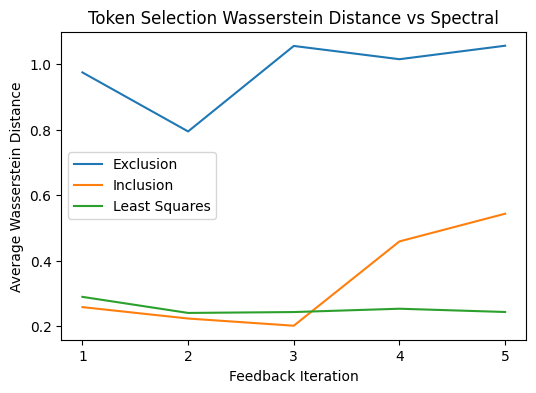

In [3]:
from scipy.stats import wasserstein_distance

exp1 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=exclusion_maxspecorder=10"
exp2 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=inclusion_maxspecorder=10"
exp3 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=lasso_maxspecorder=10_lassolambda=0.0"
# exp4 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=lasso_maxspecorder=10_lassolambda=0.005"
exp4 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
exp_names = [exp1, exp2, exp3, exp4]
exp_labels = ['Exclusion', 'Inclusion', 'Least Squares', 'Spectral']

target_protein = None
res = count_step_interactions(exp_names, exp_labels, target_protein)

spec_select = res['Spectral']

all_wasserstein = {}

compare_labels = ['Exclusion', 'Inclusion', 'Least Squares']

for label in compare_labels:
    wassersteins = []
    for feedback_it in range(len(spec_select)):
        wasserstein_avg = 0.0
        for s, s_comp in zip(spec_select[feedback_it],res[label][feedback_it]):
            wasserstein_avg += wasserstein_distance(s, s_comp)
        wassersteins.append(wasserstein_avg / len(spec_select[feedback_it]))
    all_wasserstein[label] = wassersteins

fig, ax = plt.subplots(figsize=(6,4))

bins = np.arange(1, len(spec_select) + 1, dtype=int)
for label in compare_labels:
    ax.plot(bins, all_wasserstein[label], label=label)

ax.set_xlabel("Feedback Iteration")
ax.set_ylabel("Average Wasserstein Distance")
ax.set_xticks(bins)
ax.legend()

title = "Token Selection Wasserstein Distance vs Spectral"
if target_protein is not None:
    title += f": {target_protein}"
plt.title(title)
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

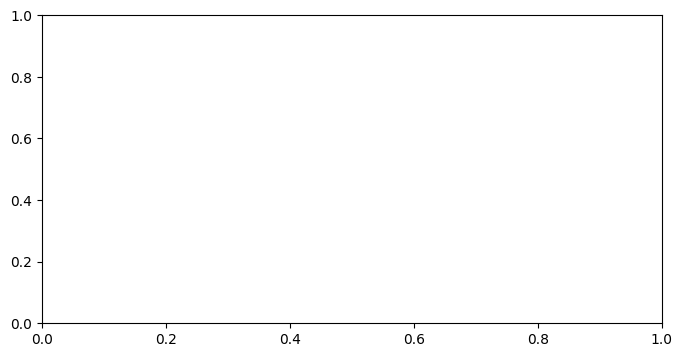

In [4]:
spec_it = 1

fig, ax = plt.subplots(figsize=(8, 4))

# Number of groups (x-axis positions)
n = len(res[exp_labels[0]][0])
x = np.arange(1, n + 1)

# Bar width and offsets based on number of experiments
total_width = 0.8
bar_width = total_width / len(exp_labels)
offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, len(exp_labels))

# Distinct colors from matplotlib’s built-in palette
colors = sn.color_palette("Set2", len(exp_labels))

for i, label in enumerate(exp_labels):
    test = np.array(res[label][spec_it-1])
    ax.bar(x + offsets[i], test, width=bar_width, label=label, color=colors[i], alpha=0.85)

ax.legend()
ax.set_xlabel('Amino Acid')
ax.set_ylabel('Selection Count')
ax.set_title(f'Amino Acid Selection Frequency: Iteration {spec_it}')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [55]:
import ast

def print_selected_groups(exp, target_protein=None, threshold=0):
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"
    df = pd.read_csv(base_dir + exp + ".csv")
    if target_protein is not None:
        df = df[df["protein_name"] == target_protein + ".pdb"]
        
    for d in df.itertuples():
        spec_selects = ast.literal_eval(d.spec_selections) # type: ignore
        top_coeffs = ast.literal_eval(d.top_spec_interactions) # type: ignore
        seq = str(d.seq)
        true_seq = str(d.true_seq)
        if len(spec_selects) > 0:
            spec_selects = spec_selects[0]
        if len(top_coeffs) > 0:
            top_coeffs = top_coeffs[0]

        selected_groups = []
        if len(top_coeffs) > 0:
            for vars, val in top_coeffs:
                if len(vars) > threshold: #and all(x in spec_selects for x in vars):
                    selected_groups.append((vars, val, tuple(seq[i] for i in vars), tuple(true_seq[i] for i in vars)))
        else:
            selected_groups = spec_selects
        print(f"Generated: {seq}")
        if target_protein is None: print(f"Output: {true_seq}")
        diff = "".join(seq[i] if seq[i] != true_seq[i] else '-' for i in range(len(seq)))
        print(f"Diff: {diff}")
        print(f"Top Interactions: {selected_groups}")
        print()

In [56]:
target_protein = '7JJK'

In [57]:
spec_exp = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
print_selected_groups(spec_exp, target_protein=target_protein, threshold=1)

Generated: AVPDAFDVWAAEMRPELAAAYPDADDAELAARLAELWAALTPAERAPYVARAAALAA
Diff: AVPD--D---AEM--E--A-Y-D-DD--LAAR-AEL-AA-TPAERA--VAR-AALAA
Top Interactions: [([12, 35], -0.02, ('M', 'L'), ('H', 'E')), ([1, 35], 0.011, ('V', 'L'), ('P', 'E'))]

Generated: APPDAFAVWAAEERPRLAAEYPDADDAQLDELLRERWAALTPEERAPYVERAAALRA
Diff: A-PD--A---AEE--R--AEY-D-DD-QLDEL-RER-AA-TP-ERA--VER-AALRA
Top Interactions: [([31, 35], -0.014, ('L', 'R'), ('Q', 'E'))]

Generated: AAPDAFAVWAAEQRPELAARYPDADDEQLDALLRERWAALTPAEKAPYEARAAALAA
Diff: AAPD--A---AEQ--E--ARY-D-DDEQLDAL-RER-AA-TPAE-A--EAR-AALAA
Top Interactions: [([12, 35], -0.032, ('Q', 'R'), ('H', 'E')), ([12, 15], 0.019, ('Q', 'E'), ('H', 'A'))]

Generated: APPDAFEVWAAEMRPLLAAAYPDADDEELDALLRELWAALTPEERAPYVERAAALAA
Diff: A-PD--E---AEM--L--A-Y-D-DDE-LDAL-REL-AA-TP-ERA--VER-AALAA
Top Interactions: []

Generated: AVPDAFAVWAARERPELAAAYPDADDAQLDELLRERWAKLTPEERAPYEAEAARLAA
Diff: AVPD--A---ARE--E--A-Y-D-DD-QLDEL-RER-A--TP-ERA--EA--ARLAA
Top Interactions: [([12, 35], -0.021,

In [8]:
lsq_exp = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=lasso_maxspecorder=10_lassolambda=0.0"
print_selected_groups(lsq_exp, target_protein=target_protein)

[33, 13, 14, 15, 46, 47, 48, 49, 26, 29]
[33, 34, 3, 42, 12, 13, 44, 46, 18, 22]
[32, 35, 4, 6, 38, 9, 42, 12, 13, 18]
[1, 2, 33, 34, 10, 11, 46, 47, 16, 17]
[33, 34, 3, 40, 42, 14, 46, 47, 53, 54]
[3, 37, 43, 45, 46, 47, 21, 22, 54, 27]
[33, 8, 9, 43, 13, 47, 16, 52, 58, 31]
[3, 36, 7, 42, 43, 47, 19, 52, 27, 30]
[33, 2, 42, 43, 13, 45, 46, 47, 48, 56]
[33, 3, 9, 10, 42, 43, 44, 46, 47, 54]


In [9]:
ll_exp = "pretrained_test_protgpt_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
print_selected_groups(ll_exp, target_protein=target_protein, threshold=1)

[([33, 47], -0.543), ([32, 35], 0.413), ([32, 47], 0.331)]
[([37, 44], 0.197), ([33, 47], -0.189)]
[([43, 44], -0.426), ([3, 47], -0.376), ([33, 47], -0.348)]
[([33, 47], -0.4)]
[([33, 47], -0.301), ([32, 35], 0.264)]
[([44, 58], -0.373), ([21, 44], -0.225)]
[([33, 48], -0.272)]
[([33, 34], -0.656), ([33, 51], 0.36)]
[([32, 35], 0.469)]
[([32, 35], 0.275), ([42, 44], 0.205), ([32, 35, 44], -0.167)]


In [10]:
scrmsd_exp = "pretrained_5JRT_scrmsd_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
print_selected_groups(scrmsd_exp, target_protein=target_protein, threshold=1)
# Consistently see that (33, 47) is a positively contributing pair to reaching desired structure
# On the other hand, (13, 46) and (33, 35, 47) are negatively contributing groups to reaching desired structure

[([37, 47], -0.004)]
[([13, 46], -0.007), ([33, 47], 0.003), ([45, 46], 0.003)]
[([13, 46], -0.007), ([33, 47], 0.004), ([32, 35], -0.002), ([13, 33, 46], 0.001)]
[([13, 46], -0.006), ([33, 47], 0.006)]
[([32, 46], -0.001), ([32, 38], 0.001), ([26, 32], 0.0), ([32, 48], 0.0)]
[([33, 47], 0.002), ([33, 47, 56], -0.002), ([47, 56], -0.001), ([33, 56], -0.001)]
[([33, 47], 0.002), ([3, 29], 0.002)]
[([29, 58], -0.009), ([33, 47], 0.004), ([29, 47], -0.003), ([29, 47, 58], 0.002)]
[([35, 47], -0.004), ([33, 47], 0.004), ([33, 35, 47], -0.003), ([13, 46], -0.003)]
[([13, 46], -0.005), ([13, 46, 56], 0.002), ([13, 56], 0.002)]


In [11]:
# Protein: 5JRT (True: FSITQFVRNLGLEHLMDIFEREQITLRVLVEMGHKELKEIGINAYGHREKLIKGVERLI)
# (33, 47) was identified as a position that led to better structure, 
# worse log likelihood, and worse stability
#
# Protein: 7JJK (True: RPMNAFMVWARIHRPALAKANPAANNAEISVQLGLEWNKLSEEQKKPYYDEAQKIKE)
# (31, 33, 35) was identified to lead to higher stability
# (12, 35) however led to lower stability